In [1]:
BLACKHOLE = True


import os
import sys
from pathlib import Path


if BLACKHOLE:
    workspace_path = os.path.expandvars('$BLACKHOLE')
    sys.path.append(workspace_path+'/DeepLearning/02456_news_project/src')
    DATAPATH = Path(workspace_path+"/DeepLearning/ebnerd_data").expanduser()
else:
    DATAPATH = Path("~/ebnerd_data").expanduser()

DATASET = "ebnerd_demo"
#DATASET = "ebnerd_small"

Packages:
- torch (PyTorch)
- transformers (Huggingface)

In [2]:
import torch

print("torch version:", torch.__version__)

# Check gpu availability


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Test:
#print(torch.zeros(1).cuda())

torch version: 2.1.2+cu121
cpu


TODO HERFRA OG NED

In [3]:
from utils.data_handler import NewsDataset
import from_ebrec._constants as cs

SEED = 42
HISTORY_SIZE = 50

COLS = [
    cs.DEFAULT_USER_COL,
    cs.DEFAULT_IMPRESSION_ID_COL,
    cs.DEFAULT_IMPRESSION_TIMESTAMP_COL,
    cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    cs.DEFAULT_CLICKED_ARTICLES_COL,
    cs.DEFAULT_INVIEW_ARTICLES_COL,

    cs.DEFAULT_ARTICLE_ID_COL,
    cs.DEFAULT_AGE_COL,
    cs.DEFAULT_READ_TIME_COL
]

FRACTION = 0.01
#FRACTION = 0.1
#FRACTION = 1

# test
dataset = NewsDataset()

dataset.setup_df(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED)


In [4]:
import transformers as huggingface
from from_ebrec._nlp import get_transformers_word_embeddings
from from_ebrec._polars import concat_str_columns
from from_ebrec._articles import convert_text2encoding_with_transformers
from from_ebrec._articles import create_article_id_to_value_mapping

dataset.setup_articles_data(dataset_path = DATAPATH.joinpath(DATASET))

df_articles = dataset.df_articles

TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-base"
TEXT_COLUMNS_TO_USE = [cs.DEFAULT_SUBTITLE_COL, cs.DEFAULT_TITLE_COL]
MAX_TITLE_LENGTH = 30

# LOAD HUGGINGFACE:
transformer_model = huggingface.AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = huggingface.AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

word2vec_embedding = get_transformers_word_embeddings(transformer_model)
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH)
article_mapping = create_article_id_to_value_mapping(df=df_articles, value_col=token_col_title)



/dtu/blackhole/0f/168015/DeepLearning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/dtu/blackhole/0f/168015/DeepLearning/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
from dataloader import NRMSDataLoader

BATCH_SIZE = 64

train_dataloader = NRMSDataLoader(
    behaviors= dataset.df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False,
    batch_size=BATCH_SIZE,
)
val_dataloader = NRMSDataLoader(
    behaviors= dataset.df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False,
    batch_size=BATCH_SIZE,
)


In [26]:
#print(train_dataloader)
#print(val_dataloader)

In [8]:
from nrms import NRMSModel
from hyperparameters import hparams_nrms

hparams = hparams_nrms()

# PARAMETERS
hparams.title_size = MAX_TITLE_LENGTH
hparams.history_size = HISTORY_SIZE

# MODEL ARCHITECTURE
hparams.head_num = 20
hparams.head_dim = 20
hparams.attention_hidden_dim = 200
hparams.linear_hidden_dim = 400

hparams.use_positional_encoding = True
hparams.use_learned_positions = True

# MODEL OPTIMIZER:
hparams.optimizer = "adam"
hparams.loss = "cross_entropy_loss"
hparams.dropout = 0.2
hparams.learning_rate = 1e-4

model = NRMSModel(hparams=hparams, word2vec_embedding=word2vec_embedding, debug=False)

print(model)


NRMSModel(
  (news_encoder): NewsEncoder(
    (embedding): Embedding(250002, 768)
    (dropout): Dropout(p=0.2, inplace=False)
    (positional_encoder): PositionEncoder(
      (position_embeddings): Embedding(30, 768)
    )
    (self_attention): SelfAttention()
    (dense_layers): Sequential(
      (0): Linear(in_features=400, out_features=400, bias=True)
      (1): ReLU()
      (2): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=400, out_features=400, bias=True)
      (5): ReLU()
      (6): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=400, out_features=400, bias=True)
      (9): ReLU()
      (10): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
      (11): Dropout(p=0.2, inplace=False)
    )
    (att_layer): AttLayer2()
  )
  (user_encoder): UserEncoder(
    (title_encoder): NewsEncoder(
      (embedding): Embedding(250002,

In [9]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function and optimizer
if hparams.loss == "cross_entropy_loss":
    criterion = nn.CrossEntropyLoss() 
elif hparams.loss == "mse_loss":
    criterion = nn.MSELoss()
else:
    raise ValueError(f"Loss function {hparams.loss} not supported")

if hparams.optimizer == "adam":
    optimizer = optim.Adam(model.parameters(), lr=hparams_nrms.learning_rate)
else:
    raise ValueError(f"Optimizer {hparams.optimizer} not supported")

In [13]:
from tqdm import tqdm  # for progress bars
# Train the model 

EPOCHS = 10

# Move model to GPU if available
model.to(device)

# Training loop
train_loss_history, val_loss_history = [], []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{EPOCHS}"):
        # Unpacking of batch
        (inputs, labels) = batch
        his_input_title, pred_input_title = inputs

        # Move data to device
        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)

        labels = labels.to(device)

        # Forward pass
        outputs = model(pred_input_title, his_input_title)  
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Validation Epoch {epoch + 1}/{EPOCHS}"):
            (inputs, labels) = batch
            his_input_title, pred_input_title = inputs

            his_input_title = his_input_title.to(device)
            pred_input_title = pred_input_title.to(device)
            labels = labels.to(device)

            outputs = model(pred_input_title, his_input_title)
            loss = criterion(outputs, labels)

            #print("Output")
            #print(outputs.tolist())
            #print("Labels")
            #print(labels.tolist())
            #print("")   
            
            val_loss += loss.item()

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


Validation Epoch 1/10: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch 1/10: Train Loss = 1.6069, Val Loss = 1.6249


Validation Epoch 2/10: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch 2/10: Train Loss = 1.5924, Val Loss = 1.6323


Validation Epoch 3/10: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch 3/10: Train Loss = 1.5806, Val Loss = 1.6124


Validation Epoch 4/10: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch 4/10: Train Loss = 1.5617, Val Loss = 1.5946


Validation Epoch 5/10: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch 5/10: Train Loss = 1.5372, Val Loss = 1.5892


Validation Epoch 6/10: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch 6/10: Train Loss = 1.5006, Val Loss = 1.5926


Validation Epoch 7/10: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch 7/10: Train Loss = 1.5006, Val Loss = 1.5667


Validation Epoch 8/10: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch 8/10: Train Loss = 1.4917, Val Loss = 1.5281


Validation Epoch 9/10: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Epoch 9/10: Train Loss = 1.4687, Val Loss = 1.5746


Validation Epoch 10/10: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

Epoch 10/10: Train Loss = 1.4844, Val Loss = 1.6156


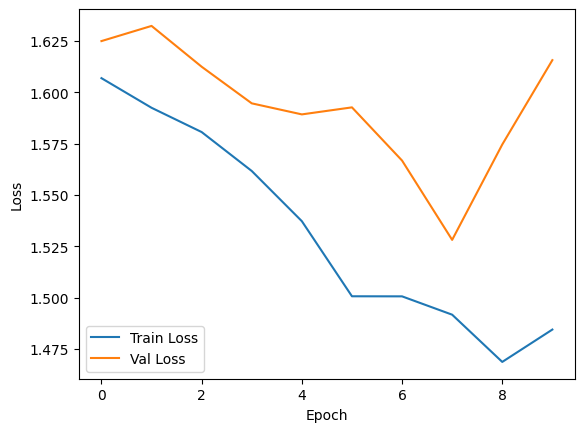

In [14]:
# Plot the loss history
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [21]:
# Evaluate the model
BATCH_SIZE_TEST = 1 # Currently onoy supports batch size 1

dataset.setup_test_data(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED)

test_dataloader = NRMSDataLoader(
    behaviors=dataset.df_test,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False, # Is true in EBREC, but then it does not work
    batch_size=BATCH_SIZE_TEST,
)

# go from [[a], [b], [c]] to [a, b, c]
def convert_to_list(l):
    return [(item) for sublist in l for item in sublist]
model.eval()

pred_test = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Test"):
        (inputs, labels) = batch
        his_input_title, pred_input_title = inputs


        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)
        labels = labels.to(device)

        outputs = model(pred_input_title, his_input_title)

        #print("Output")
        #print(outputs.tolist())
        #print("Labels")
        #print(labels.tolist())
        bob = convert_to_list(outputs.tolist())
        #print(bob)
        #print(convert_to_int_list(labels.tolist()))
        #print("")


        pred_test.append(bob)

from from_ebrec.evaluation import MetricEvaluator
from from_ebrec.evaluation import AucScore, MrrScore, NdcgScore
metrics = MetricEvaluator(
    labels= dataset.df_test["labels"].to_list(),
    predictions= pred_test,
    metric_functions=[AucScore(), MrrScore(), NdcgScore(k=5), NdcgScore(k=10)],
)
metrics.evaluate()

AUC: 100%|█████████████████████████████████| 253/253 [00:00<00:00, 17770.09it/s]


<MetricEvaluator class>: 
 {
    "auc": 0.5210856883031735,
    "mrr": 0.31295745322421925,
    "ndcg@5": 0.35249752866881456,
    "ndcg@10": 0.42783494394049787
}

In [22]:
number_to_print = 20
print("Top %d predictions vs labels:" % number_to_print)
labels = dataset.df_test["labels"].to_list()
for i in range(number_to_print):
    print(f"Article {i}")
    for j in range(len(pred_test[i])):
        print(f"{pred_test[i][j]:.3f} vs {labels[i][j]:.3f}")
    print("")





Top 20 predictions vs labels:
Article 0
0.002 vs 0.000
0.054 vs 0.000
0.071 vs 0.000
0.014 vs 0.000
0.007 vs 1.000
0.024 vs 0.000
0.005 vs 0.000
0.443 vs 0.000
0.186 vs 0.000
0.057 vs 0.000
0.015 vs 0.000
0.083 vs 0.000
0.005 vs 0.000
0.013 vs 0.000
0.001 vs 0.000
0.019 vs 0.000
0.001 vs 0.000

Article 1
0.077 vs 0.000
0.336 vs 1.000
0.326 vs 0.000
0.213 vs 0.000
0.048 vs 0.000

Article 2
0.006 vs 1.000
0.004 vs 0.000
0.451 vs 0.000
0.011 vs 0.000
0.000 vs 0.000
0.529 vs 0.000

Article 3
0.100 vs 1.000
0.218 vs 0.000
0.000 vs 0.000
0.001 vs 0.000
0.000 vs 0.000
0.343 vs 0.000
0.000 vs 0.000
0.001 vs 0.000
0.332 vs 0.000
0.005 vs 0.000

Article 4
0.000 vs 0.000
0.001 vs 0.000
0.225 vs 0.000
0.001 vs 0.000
0.183 vs 0.000
0.154 vs 0.000
0.049 vs 0.000
0.001 vs 0.000
0.021 vs 0.000
0.003 vs 0.000
0.097 vs 0.000
0.002 vs 0.000
0.041 vs 0.000
0.000 vs 0.000
0.005 vs 0.000
0.009 vs 0.000
0.086 vs 0.000
0.060 vs 1.000
0.062 vs 0.000
0.000 vs 0.000

Article 5
0.000 vs 0.000
0.000 vs 0.000
0.059

Confusion Matrix:
[[2956  102]
 [ 235   18]]


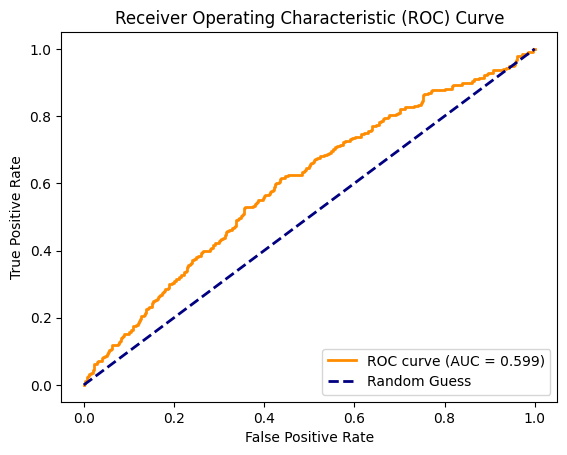

In [25]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


# Flatten the data for analysis
predicted_probabilities = [prob for article in pred_test for prob in article]
true_values = [val for article in labels[:len(pred_test)] for val in article]

# Set a threshold (commonly 0.5) to classify probabilities as 0 or 1
threshold = 0.5
predicted_classes = [1 if p >= threshold else 0 for p in predicted_probabilities]

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_values, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate AUC and ROC curve
fpr, tpr, thresholds = roc_curve(true_values, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with AUC value explicitly highlighted
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()